# Data analysis project
Let's have a look at the level of tourism in Denmark. Statistics Denmark have records of the number of visiting tourists from 2014:1 - 2019:1, so we can see how the tourism in Denmark has evovled over the years. The exact definition of af tourist in this data is a person staying overnight at one of the following places:
- Hotels
- Holiday resorts
- Camping sites	Youth hostels
- Marinas
- Holiday cottages

In order to analys the data, it is first nessesary to importing and prepare the data.

# Preparing the data

## Import packages and load the data
We start by importing the relevant packages for our analysis

In [7]:
# Imporing packages
import pandas
import datetime
import matplotlib.pyplot as plt
import pydst
import calendar
from statsmodels.tsa.seasonal import seasonal_decompose
import geopandas as gpd
import ipywidgets as widgets

We then use the API for data extractions from Statistics Denmark. The data will be imported in English from the table called 'TURIST'.

In [8]:
Dst = pydst.Dst(lang='en')
Dst.get_data(table_id = 'TURIST');

For the preparation of the data extraction, the following code provides an overlook of the variables to choose from. The relevant categories within each variable is then chosen for the final list of variables "var_list" to be included in the analysis. The final data extract will be stored in a data frame called 'df'.

In [9]:
# Display the different categories for each variable in the dataset
indk_vars = Dst.get_variables(table_id='TURIST')
indk_vars['values'][2][:50];

In [10]:
# Specific categories for each variable is chosen as a dictionary
var_list      = {'OVERNATF':['100'],\
                 'OMRÅDE':['000','084','085','083','082','081'],\
                 'NATION1':['*'],\
                 'PERIODE':['01','02','03','04','05','06','07','08','09','10','11','12'],\
                 'TID':['*']}

# The raw data frame with the specified variables is imported and a sample is given below
df            = Dst.get_data(table_id = 'TURIST', variables=var_list);
df.sample(3)

,OVERNATF,OMRÅDE,NATION1,PERIODE,TID,INDHOLD
69918,All types,Region Sjælland,Germany,July,2009,52449
22892,All types,Region Sjælland,Netherlands,September,1997,..
19081,All types,Region Sjælland,South korea,February,1996,..


## Setup the final data frame
The extracted data frame 'df' now contains the basic data, but some corrections have to be made. The variables in the data frame can be described as below:

- **OVERNATF:** The types of ways to live in Denmark as a tourist. Since we do not care how they stay in the country, we only use the 'All types' category.
- **OMRÅDE:**   The different administrative areas, where the tourists are staying throughout their visit.
- **NATION1:**  The nationality of the tourists.
- **PERIODE:**  The period where the observations has been recorded. We only care about the months, so the rest of the categories has been dropped.
- **TID:**      The time of the observations. This means, which year the observations were recorded. Statistic Denmark only have observations for the time 2014-2019, but since only the first month of 2019 is accounted for, 2019 will be dropped from the final data set.
- **INDHOLD:**  The total number of observed tourists from a specific nation, at a given area, at a specific year and month.

Some observations are empty, so the number of tourists is given as '..'. This is a problem when we have to do calculations. The empty observations are then replaced with zeroes and the variable is formatted into a number (integer).

A timeseries would also be nice to have for a visual look at the evolution in the number of tourists. For this we have to make a date variable. The datetime function is useful here, but we have to translate the name of each month into a number to use the function. The corrections for the final data set is done below. 

In [11]:
# Replace empty observations and format the variable
df['INDHOLD'] = df['INDHOLD'].replace('..', '0').astype(str).astype(int)

# Dictionary to transform the name of the month to a number
dic           = {'January':'01', 'February':'02', 'March':'03', 'April':'04', 'May':'05', 'June':'06',\
                 'July':'07', 'August':'08', 'September':'09', 'October':'10', 'November':'11', 'December':'12'}

# Making a variable for the date, using datetime
df['Month']   = df['PERIODE'].replace(dic)
df['Month']   = df['Month'].astype(str).astype(int)
df['day']     = 1
df['year']    = df['TID']
df['Date']    = pd.to_datetime(df[['year', 'Month', 'day']])

# We ony want to use years with observations
df            = df[(df['Date'].dt.year > 2013)]
df            = df[(df['Date'].dt.year < 2019)]

# Restructuring the data frame
df            = df.set_index('Date')
df            = df[['OMRÅDE','NATION1','year','Month','PERIODE','day','INDHOLD']]
df.sample(3)

,OMRÅDE,NATION1,year,Month,PERIODE,day,INDHOLD
Date,,,,,,,
2016-08-01,Region Nordjylland,Romania,2016,8,August,1,164
2018-02-01,Region Sjælland,Bulgaria,2018,2,February,1,15
2015-12-01,All Denmark,Greenland,2015,12,December,1,1990


## Splitting the data frame
The restructured data frame 'df' contains both observations for 'All Denmark' and for each of the 5 regions. For the timeseries we only want the observations for 'All Denmark' and only for foreign tourist, which means we have to remove the observations for Danish tourists. An easy way to do this is by only including the value 'World outside Denmark' for nationality. The following code creates the data frame with total number of tourists for each month and year based on their nationality.

In [12]:
# Total number of observations each month of the year for foreign tourists
AD = df[df['OMRÅDE'] == 'All Denmark']
AD = AD[AD.NATION1.isin(['World outside Denmark'])]

# Overview of the level of tourism in Denmark

## Total number of tourists from 2014-2018
Just to get a quick overlook of the number of tourist in Denmark over the years, a timeseries is drawn. This is done from the calculated data frame AD, which sums the number of tourists grouped by each date. A rolling mean is calculated to get a better feel for the trend in the time series.

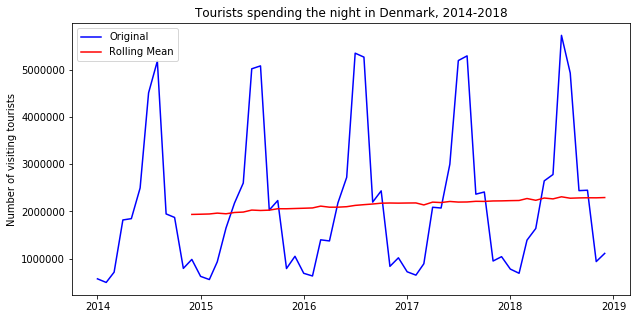

In [15]:
# Sum total number of tourists for each date
AD_sum = AD.groupby(['Date'])['INDHOLD'].sum()

# Calculating the rolling mean
rolmean = AD_sum.rolling(12).mean()

# Plot timeseries and mean
plt.figure(figsize=(10, 5))
plt.plot(AD_sum, color='blue',label='Original')
plt.plot(rolmean, color='red', label='Rolling Mean')
plt.legend(loc='best')
plt.ylabel('Number of visiting tourists')
plt.title('Tourists spending the night in Denmark, 2014-2018')
plt.show()

It is clear and also expected, that the number of tourists is extremely seasonal. The number of tourists are lowerst (0.5-1 mio.) at the end and the beginning of each year (winter season), while being around 5-5.5 mio. in the peak seasons (summer). Over the five years, the overall level also seems to have increased. It is possible to see from the rolling mean, but it could also be from a higher seasonal effect. To ease the task of analysis the overall level, it would be easier to decompose the timeseries. By imposing a multiplicative model, we get a time series for the trend in levels and the seasonal effect and the residual in percentage. 

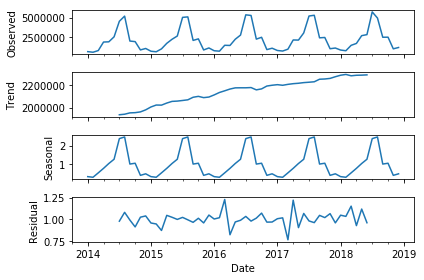

In [18]:
# The decomposition of the time series
decomp = seasonal_decompose(AD_sum, model='multiplicativ')
decomp.plot()
plt.show()

The results tell that a clear linear trend is present in the time series. Denmark has either become a more popular travel destination or people are traveling more in general. The seasonal effect is clear in the decomposition and from the residual, it appears that most deviations from the expected happens in the first months of the year. That means most uncertainty happens around the winter season. 

In order to get a better feel of the seasonal effects, the aggregated mean level of each month over the five-year period is calculated below. This gives a nice view of how popular each month is to visit Denmark in. The code below groups the data frame by each month and takes a mean over the five years.

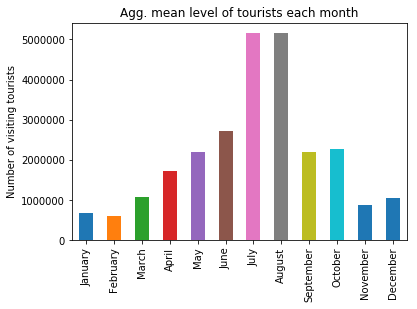

In [19]:
# Aggregated mean level of each month of the five-year period
ax = AD.groupby('Month')['INDHOLD'].mean().plot.bar()

# Labels and title of the bar chart is constructed
ax.set_ylabel('Number of visiting tourists');
ax.set_xlabel('');
ax.set_xticklabels(calendar.month_name[1:13])
ax.set_title('Agg. mean level of tourists each month');

July and August are the clear winners as the months with the highest number of tourists. It is due to people visiting Denmark during their summer holidays. The number of tourists visiting Denmark each of the two months is almost the same amount as the total population in Denmark. The number of foreign tourists each month is almost never under 1 mio., which is quiet high for a small country as Denmark. This means Denmark is a well visited country, relative to its size.

# Characteristics for the tourists
Now that we know Denmark is well visited, it could be interesting to see which nationalities are visiting Denmark most frequently. By calculating an average number of tourists each year, based on nationality, it is possible to make a top 10 of most visiting nationality over the last five years on average.

In [22]:
# Only choose obs for Denmark as a whole
reg  = df[df['OMRÅDE'] == 'All Denmark']

# Only choose obs based on specific nationalies and not agg. categories
reg  = reg[~reg.NATION1.isin(['Total','Denmark','World outside Denmark'])]

# The sum of each year for each nationality used for the avg. over the five years
reg2 = reg.groupby(['NATION1','year'])['INDHOLD'].sum().to_frame()
reg3 = reg2.groupby(['NATION1'])['INDHOLD'].mean().to_frame()
print('Top 10 over most visiting nationality on average')
reg3.sort_values(by = ['INDHOLD'], ascending=[False]).head(10)

Top 10 over most visiting nationality on average


,INDHOLD
NATION1,
Germany,14482293.8
Norway,2483358.8
Sweden,1839920.8
Netherlands,1192100.6
United Kingdom,840709.6
USA,637028.4
Unknown country,553392.4
Rest of Europa,334457.8
Italy,324722.0


This top 10 clearly shows how dominant the German tourists are in Denmark, but since we only have a table with the numbers above, it can be difficult to compare the level of tourists across the nationalities. Lets try and make a nice looking bar chart, to ease the comparison.

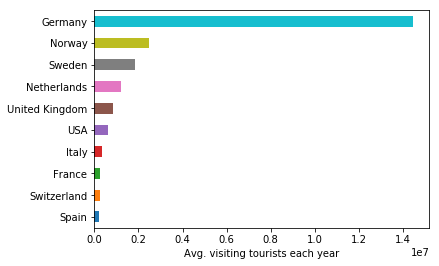

In [30]:
# List and new dataframe of our top 10  
lande   = ['Germany','Norway','Sweden','Netherlands','United Kingdom','USA','Italy','France','Switzerland','Spain']
reg_top = reg[reg.NATION1.isin(lande)]

# The new dataframe is used to calculated the mean of tourists over the five years
ax      = reg_top.sort_values(by = ['INDHOLD'], ascending=[False]).groupby(['NATION1','year'])['INDHOLD'].sum().to_frame()
axm     = ax.groupby(['NATION1'])['INDHOLD'].mean().to_frame()

# A bar chart of the top 10 most visiting nationalities for better comparison
axm['INDHOLD'].sort_values(ascending=[True]).plot.barh();
plt.gca().set_ylabel('')
plt.gca().set_xlabel('Avg. visiting tourists each year')
plt.show()

The average level of visiting Germans each year is 14,5 mio. compared to Norway on second place with only 2,5 mio. This tells us that most of the visiting tourists are from Germany. The second and third place is Norway and Sweden, so Denmark is most visited by its neighbors.

The number of tourists from Germany is so high, that it can be hard to compare the other nations in the chart. To solve this problem, Germany is removed below in a new chart. The conclusion is, that the countries closest to Denmark are the most frequent visiting nations. USA is more present in the tourism compared to nationas from Southern Europe, but it is also a relative more populated nation. Italy, France, Switzerland and Spain are all on the same level of tourism in Denmark.

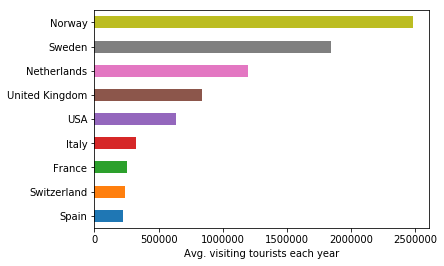

In [31]:
# Drop observation from Germany
axm2 = axm.drop(axm.index[1])

# Sort again and plot the bar chart
axm2['INDHOLD'].sort_values(ascending=[True]).plot.barh();
plt.gca().set_ylabel('')
plt.gca().set_xlabel('Avg. visiting tourists each year')
plt.show()

Statistics Denmark has also provided data for how many of the tourists are staying in each of the five regions in Denmark. Since the data is available, let’s have a look at where the tourists are staying while visiting Denmark.

# Where tourists stay while in Denmark
It is possible to draw a map of Denmark from a shapefile (.shp). By providing the observations with the relevant geometric values, geopandas can draw a map showing with colors, which of the five regions is most popular in Denmark to visit by tourists.

First we start by preparing the polygon from the shapefile, used to draw the map.

In [25]:
# Importing the shapefile
map_df = gpd.read_file("Geofiles/DNK_adm1.shp")

# Dictionary is constructed in order to rename the regions for the merge
regs           = {'Hovedstaden':'Region Hovedstaden','Midtjylland':'Region Midtjylland','Nordjylland':'Region Nordjylland',\
                 'SjÃ¦lland':'Region Sjælland','Syddanmark':'Region Syddanmark'}

# In order to merge, the variables has to be named the same
map_df['OMRÅDE'] = map_df['NAME_1'].replace(regs)
map_df1 = map_df[['OMRÅDE','geometry']]
# This is the dataframe, ready to be merged on the observations
map_df1

,OMRÅDE,geometry
0,Region Hovedstaden,(POLYGON ((14.77472305297852 55.29875183105469...
1,Region Midtjylland,(POLYGON ((10.31305503845226 55.79124832153332...
2,Region Nordjylland,(POLYGON ((8.542498588562069 56.70430374145502...
3,Region Sjælland,(POLYGON ((11.51249980926525 54.62541580200201...
4,Region Syddanmark,(POLYGON ((10.58416652679443 54.85031509399425...


Now that the coordinates for regions on the map is ready, it can be merged on the original dataframe 'df'. In order to compare the evolution over time, a slider with the years is introduced for the reader to play around with.

In [34]:
def interactive_figure(y):
    
    # The original dataframe with obs for the regions
    lo = df[df['OMRÅDE'] != 'All Denmark']
    lo = lo[~lo.NATION1.isin(['Total','Denmark','World outside Denmark'])]
    lo = lo[lo.year.isin([y])]
    
    # The observations are aggregated by each region in Denmark
    tmp = lo.groupby(['OMRÅDE'])['INDHOLD'].sum().to_frame()
    # The observations are merge with the shapefile data on the regions
    maps = pd.merge(map_df1, tmp, on='OMRÅDE')

    # create the figure and the axes for the plot
    fig, ax = plt.subplots(1, figsize=(16, 4))
    maps.plot(column='INDHOLD', cmap='viridis_r', ax=ax)
    ax.axis('off');

    # set max/min for the legend
    vmin = maps['INDHOLD'].min()
    vmax = maps['INDHOLD'].max()

    # create legend
    sm = plt.cm.ScalarMappable(cmap='viridis_r', norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []
    cbar = fig.colorbar(sm)

In [27]:
# The implimentation of a widget makes it possible to change which nationality we want to take a closer look at
widgets.interact(interactive_figure,
    y=widgets.SelectionSlider(description="$Year$", options=['2014','2015','2016','2017','2018'], value='2018'),);

interactive(children=(SelectionSlider(description='$Year$', index=4, options=('2014', '2015', '2016', '2017', …

The maps above show the total amount of tourists for each region. The year can be adjusted by the slider. The maps show that the relative level of tourists is constant over the five years, where the only difference is the total amount of tourists increasing over the years.

The conclusion is that most tourists visit 'Region Hovedstaden', where Copenhagen must be the main reason. Bornholm is also an attractive holiday location in the summer, which is also a part of 'Region Hovedstaden', but compared to Copenhagen, Bornholm do not have that many locations for accommodation. The second most visited region is 'Region Syddanmark'. This is could be a result of many tourists crossing the border between Germany and Denmark on their way further into Denmark/Europe. A closer look at the distribution of nationalities in each region could explain some of these results.

The following pie chart is an interactive way of examine where the tourists of each nationality is staying while in Denmark. Since the maps show their is no realtive difference over time, the pie charts will be the sum over all five years.

In [37]:
# We start with a function genrating the pie chart.
def interactive_figure(fokus):
    # Choose nationality for the pie chart
    lo = df[df['OMRÅDE'] != 'All Denmark']
    lo1 = lo[lo.NATION1.isin([fokus])]
    
    # Sum the observations grouped by the regions and plot the chart
    pie_sources = lo1.groupby(['OMRÅDE'])['INDHOLD'].sum().plot(kind='pie',autopct='%1.1f%%')
    plt.gca().set_ylabel('')
    plt.title('Share of tourists from the chosen country by region in Denmark')
    plt.show()

In [40]:
# The implimentation of a widget makes it possible to change which nationality we want to take a closer look at
widgets.interact(interactive_figure,
    fokus=widgets.Dropdown(description="$Nationality$", options=lande, value='Germany'),);

interactive(children=(Dropdown(description='$Nationality$', options=('Germany', 'Norway', 'Sweden', 'Netherlan…

The results show that tourists from Southern Europe (France, Spain, Italy) and countries where people have to fly to Denmark (USA, United Kingdom) has the highest percentages in Region Hovedstaden. It might be that most tourists come to Denmark in order to visit Copenhagen and if you fly to Kastrup, you do not have to stay overnight at some other place in Denmark than Region Hovedstaden. The European countries more to the north like Netherlands and Switzerland are more likely to visit Region Syddanmark. There might be some interesting things to see in Region Syddanmark, but since most of the tourists are traveling to Copenhagen, it could be that tourists from countries closer to Denmark are traveling by car. If you then have to stop and rest on your journey, it might be in Region Syddanmark on the way to Copenhagen.

A relatively large percentage of tourists from Sweden and Norway also stay in Region Syddanmark. This might be a reversed situation as for the people traveling to Copenhagen by car. If Swedish or Norwegian tourists are traveling down south into Europe, then they might have to rest in Region Syddanmark on their way.

Region Syddanmark do not have to be a resting place for people traveling across Denmark. Odense is a major city in Denmark, with attractions like H.C. Andersen, which could be a magnet for tourists. 

The final **conclusion** is that Denmark is a well visited country, mostly by its neighbors and during the summer, the number of people living in Denmark almost double in size.